# Spectra acquisiton
Control both the stepping motor and the camera from this notebook.<br>
Make a loop to measure a wide-range spectrum automatically.

NOTE: only one connection to COM port is possible at a time. Shut down other connections, either in python or dedicated software.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from lab_control.spectrometer import thr640
from lab_control import pwr01

In [3]:
import sys
sys.path.append('../')

In [4]:
import time, os, logging
from FLI import FLI
import numpy as np
import xarray as xr
from os.path import join
import csv

In [5]:
%run thr640.py
%run imaging_tool.py

In [6]:
# logger
logger = thr640.logger
camera = FLI()
step_motor = thr640.THR640()

In [7]:
pwr = pwr01.PWR01()

In [14]:
pwr.set_current(0.5)
pwr.set_voltage(350)
pwr.output_on()

In [15]:
basepath = r'\\10.249.254.51\Public\takeoka\Spectraacquisition_takeoka_20201105'
os.path.exists(basepath)

True

In [16]:
join(basepath,'a.nc')

'\\\\10.249.254.51\\Public\\takeoka\\Spectraacquisition_takeoka_20201105\\a.nc'

\\10.249.254.51\Public\takeoka\Spectraacquisition_takeoka_20201105\H_420000_1.nc
\\10.249.254.51\Public\takeoka\Spectraacquisition_takeoka_20201105\H_420000_2.nc
\\10.249.254.51\Public\takeoka\Spectraacquisition_takeoka_20201105\H_420000_3.nc
\\10.249.254.51\Public\takeoka\Spectraacquisition_takeoka_20201105\H_425000_1.nc
\\10.249.254.51\Public\takeoka\Spectraacquisition_takeoka_20201105\H_425000_2.nc
\\10.249.254.51\Public\takeoka\Spectraacquisition_takeoka_20201105\H_425000_3.nc
\\10.249.254.51\Public\takeoka\Spectraacquisition_takeoka_20201105\H_430000_1.nc
\\10.249.254.51\Public\takeoka\Spectraacquisition_takeoka_20201105\H_430000_2.nc
\\10.249.254.51\Public\takeoka\Spectraacquisition_takeoka_20201105\H_430000_3.nc
\\10.249.254.51\Public\takeoka\Spectraacquisition_takeoka_20201105\H_435000_1.nc
\\10.249.254.51\Public\takeoka\Spectraacquisition_takeoka_20201105\H_435000_2.nc
\\10.249.254.51\Public\takeoka\Spectraacquisition_takeoka_20201105\H_435000_3.nc
\\10.249.254.51\Public\takeo

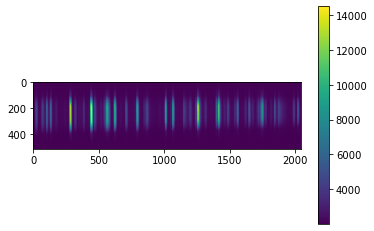

In [17]:
exposure = 1.5 * 1e2 # ms
vbin = 1
attributes = {
    "temperature": camera.getTemperature(),
    "device_status": camera.getDeviceStatus(),
    "exposure": exposure,
    "frame_type": "light",
    "motor_coordinate":"",
    'voltage': pwr.get_voltage(),
    'current': pwr.get_current()
}

#R = [100000 + i*5000 for i in range(101)]
#R = [605000 + i*5000 for i in range(20)]
#R = [380000 + i*5000 for i in range(25)]
#R = [500000 + i*5000 for i in range(5)]
#R = [400000 + i*9000 for i in range(15)]
R = [420000 + i*5000 for i in range(14)]
for r in log_progress(R):
    for j in range(3):
        if j%3==0:
            current=0.1
        elif j%3==1:
            current=0.2
        else:
            current=0.3
            
        pwr.set_current(current)
 
        
        
        step_motor.goto(r)
        step_motor.waitUntilReady()
        attributes['motor_coordinate'] = r
    
        camera.setExposureTime(exposure)
        camera.setVBin(vbin)
        camera.setImageArea(10,0,2058,512//vbin)
        time.sleep(.5)
        camera.exposeFrame()
        time.sleep(.1)
        # load image
        image_data = camera.grabFrame(out=np.empty((512//vbin,2048), np.uint16))
        # convert to xarray
        data = xr.DataArray(
            image_data, dims=["y", "x"], coords={"image_counter": 0}, attrs=attributes
        )
        # save data as NetCDF file
        filepath = join(basepath,f'H_{r}_{j+1}.nc')
        print(filepath)
        data.to_netcdf(filepath)
    
print('Done.')
imshow(image_data)
colorbar()

In [8]:
[430000 + i*5000 for i in range(10)]

[430000,
 435000,
 440000,
 445000,
 450000,
 455000,
 460000,
 465000,
 470000,
 475000]